In [73]:
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

with open('/Users/adamwagnerhoegh/Documents/Legal data/domsdatabasen.retsinformation_newer.json') as f:
    retsinfo = json.load(f)

In [74]:
# Inspecting the structure
retsinfo[0]['kapitler'][0]['paragraffer']

[{'nummer': '§ 1.',
  'index': 0,
  'stk': [{'tekst': 'Formålet med denne lov er at sikre forældre ret til fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov m.v. og at sikre forældre ret til fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov m.v. og at sikre forældre med tilknytning til arbejdsmarkedet ret til barselsdagpenge under fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov og at sikre ret til dagpenge ved pasning af alvorligt syge børn m.v.',
    'index': 0}]}]

In [75]:
# Inspecting the structure
retsinfo[0]['kapitler']

[{'nummer': 'Kapitel 1',
  'titel': 'Formål',
  'paragraffer': [{'nummer': '§ 1.',
    'index': 0,
    'stk': [{'tekst': 'Formålet med denne lov er at sikre forældre ret til fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov m.v. og at sikre forældre ret til fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov m.v. og at sikre forældre med tilknytning til arbejdsmarkedet ret til barselsdagpenge under fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov og at sikre ret til dagpenge ved pasning af alvorligt syge børn m.v.',
      'index': 0}]}]},
 {'nummer': 'Kapitel 2',
  'titel': 'Afgrænsning af personkredsen, der har ret til fravær og barselsdagpenge efter denne lov',
  'paragraffer': [{'nummer': '§ 2.',
    'index': 0,
    'stk': [{'tekst': 'Ret til fravær efter denne lov omfatter alle forældre.',
      'index': 0},
     {'tekst': 'Dagpenge ef

In [76]:
# Inspecting the structure
retsinfo[0]['kapitler'][0]['paragraffer'][0]['stk'][0]['tekst']

'Formålet med denne lov er at sikre forældre ret til fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov m.v. og at sikre forældre ret til fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov m.v. og at sikre forældre med tilknytning til arbejdsmarkedet ret til barselsdagpenge under fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov og at sikre ret til dagpenge ved pasning af alvorligt syge børn m.v.'

In [77]:
# Inspecting
retsinfo[0]['kapitler'][1]['paragraffer'][0]['stk'][0]

{'tekst': 'Ret til fravær efter denne lov omfatter alle forældre.', 'index': 0}

In [78]:
# Ide: tjek længder af paragraffer. Hvis de er omkring 450 tokens kan det være at det kun er en af gangen der skal retrieves.
# Hvis det er tilfældet kan du måske frasortere alle paragraffer der er længere end 512 minus 50 tokens (context window minus maks længde genereret tekst)

parse_list = []

idx = 0

for lov in tqdm(retsinfo):
    for kapitel in lov['kapitler']:
        for paragraffer in kapitel['paragraffer']:
            temp_paragraf_list = []
            for styk in paragraffer['stk']:
                temp_paragraf_list.append(styk['tekst'])
            parse_list.append(temp_paragraf_list)


100%|██████████| 1637/1637 [00:00<00:00, 44188.07it/s]


In [79]:
# Collapsing list of lists of texts into list of texts
rag_list = [' '.join(item) for item in parse_list]

In [80]:
# Inspecting structure
parse_list[2][2]

'Barselsdagpenge kan endvidere udbetales til en person, der ved fraværsperiodens begyndelse opholder sig i udlandet i en periode, som der efter § 27, stk. 3, eller § 28, stk. 2, ses bort fra ved vurderingen af, om beskæftigelseskravet er opfyldt.'

In [81]:
# Flattening list to be a list of the nested examples
finetune_list = [
    x
    for xs in parse_list
    for x in xs
]

In [82]:
# Tokenizing all the paragraps to see how long they generally are

from transformers import AutoTokenizer, T5ForConditionalGeneration

# Load the pretrained T5 model and tokenizer
model_name = "strombergnlp/dant5-large"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


/Users/adamwagnerhoegh/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [83]:
# Creating a function to tokenize

#max_length = 512-50

def count_tokens(list):
    temp_list = []
    for item in list:
        temp_list.append(len(tokenizer(item, return_tensors="pt", padding=True, truncation=True)['input_ids'][0]))
    return temp_list


In [84]:
# Creating the skeleton for the function with an example

len(tokenizer(rag_list[0], return_tensors="pt")['input_ids'][0])

104

In [85]:
# Creating a list of the token_lengths

len_tokens = count_tokens(rag_list)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


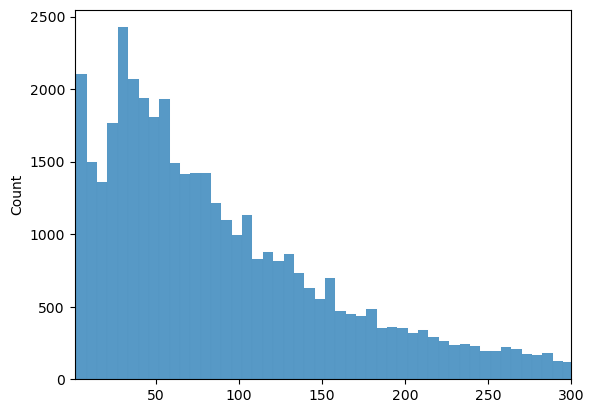

In [86]:
# Plotting the distribution of the text token lengths. This is important for RAG, as the documents being retrieved there will be on paragraf-level

fig, ax = plt.subplots()
sns.histplot(len_tokens, ax=ax)
ax.set_xlim(1, 300)
plt.show()

In [87]:
# Checking the number of examples we'll be fine-tuning on
len(finetune_list)

111499

In [88]:
# Creating a list of the length of tokens for each text
finetune_len = count_tokens(finetune_list)

In [89]:
# Checking the mean token length for each example (important for knowing how long fine-tuning will take)
count = 0

for item in finetune_len:
    count += item

print(count/len(finetune_len))

49.90753280298478


In [91]:
# Saving lists as txt-files

with open("rag_list.txt", "w") as file:
    for item in rag_list:
        file.write(f"{item}\n")

with open("finetune_list.txt", "w") as file:
    for item in finetune_list:
        file.write(f"{item}\n")